# Analyzer

In [48]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from skmisc.loess import loess

import ipystata
from ipystata.config import config_stata  
config_stata('/Applications/Stata/StataMP.app/Contents/MacOS/stata-mp')  
from IPython.display import Image

In [2]:
PATH = "/Volumes/Extreme SSD/data/analysis"

df = pd.read_pickle(os.path.join(PATH, 'vendor_week.pickle'))

In [3]:
df.loc[df['price_diff_mw'].isin([np.inf]), 'price_diff_mw'] = None

Index(['vendor', 'w', 'rating_m', 'reputation_m', 'price_usd_m', 'delta_t_m',
       'neg_rating_m', 'count_min', 'neg_count_min', 'pos_count_min',
       'price_usd_s', 'delta_t_s', 'cum_count', 'arf', 'arf_bgm', 'neg_rating',
       'international_shipment', 'item_count', 'item_count_w',
       'category_count', 'category_count_w', 'price_diff_mw', 'arm_maxw',
       'arm_bgm_maxw', 'empty_stock_last_week_maxw', 'm_maxw', 'rtime_dt_min',
       'neg_count_w', 'pos_count_w', 'has_price_drop'],
      dtype='object')

In [90]:
df['arm_maxw_shift'] = df.groupby('vendor').apply(lambda x: x['arm_maxw'].shift(1)).reset_index(drop = True).astype('bool')
df['arm_bgm_maxw_shift'] = df.groupby('vendor').apply(lambda x: x['arm_bgm_maxw'].shift(1)).reset_index(drop = True).astype('bool')
df['has_price_drop_shift'] = df.groupby('vendor').apply(lambda x: x['has_price_drop'].shift(1)).reset_index(drop = True).astype('bool')

In [91]:
shift = ['has_price_drop_shift', 'arm_bgm_maxw_shift', 'arm_maxw_shift']
df = df.dropna(subset = shift).reset_index(drop = True)

# Negative Feedbacks

In [84]:
# fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = [12,5])
# ax1.grid(True, which="both", ls="-", color='0.9')
# ax2.grid(True, which="both", ls="-", color='0.9')

# # set axes specification
# ax1.set_yscale('log')
# ax2.set_yscale('log')

# colors = {True  : 'red', False : '#1f77b4'}

# vendors = df['vendor'].nunique()
# for vendor in range(vendors):
#     # start enumeration with 1
#     vendor += 1
    
#     # get vendor specific data
#     ven = df.loc[df['vendor'] == vendor]
#     c = ven['arf'].map(colors).max()
#     y = ven['neg_count_min']
#     x = ven['w']
    
#     # plot line per selelr
#     if ven['arf'].max():
#         ax1.plot(x, y, c = c, alpha = .5, label = 'Performed ARF')
#     else:
#         ax2.plot(x, y, c = c, alpha = .5, label = 'Did not perform ARF')

# # make legends for left panel
# handles, labels = ax1.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax1.legend(by_label.values(), by_label.keys(), loc = 'upper left')

# # make legends for right panel 
# handles, labels = ax2.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax2.legend(by_label.values(), by_label.keys(), loc = 'upper left')

# # set axes
# for ax in fig.get_axes():
#     ax.label_outer()
# ax1.set_xlim(0, 50); ax2.set_xlim(0, 50)
# ax1.set_ylim(ymin = 10**0.01, ymax = 10**3.9); ax2.set_ylim(ymin = 10**0.01, ymax = 10**3.9)

# plt.tight_layout()
# plt.show()

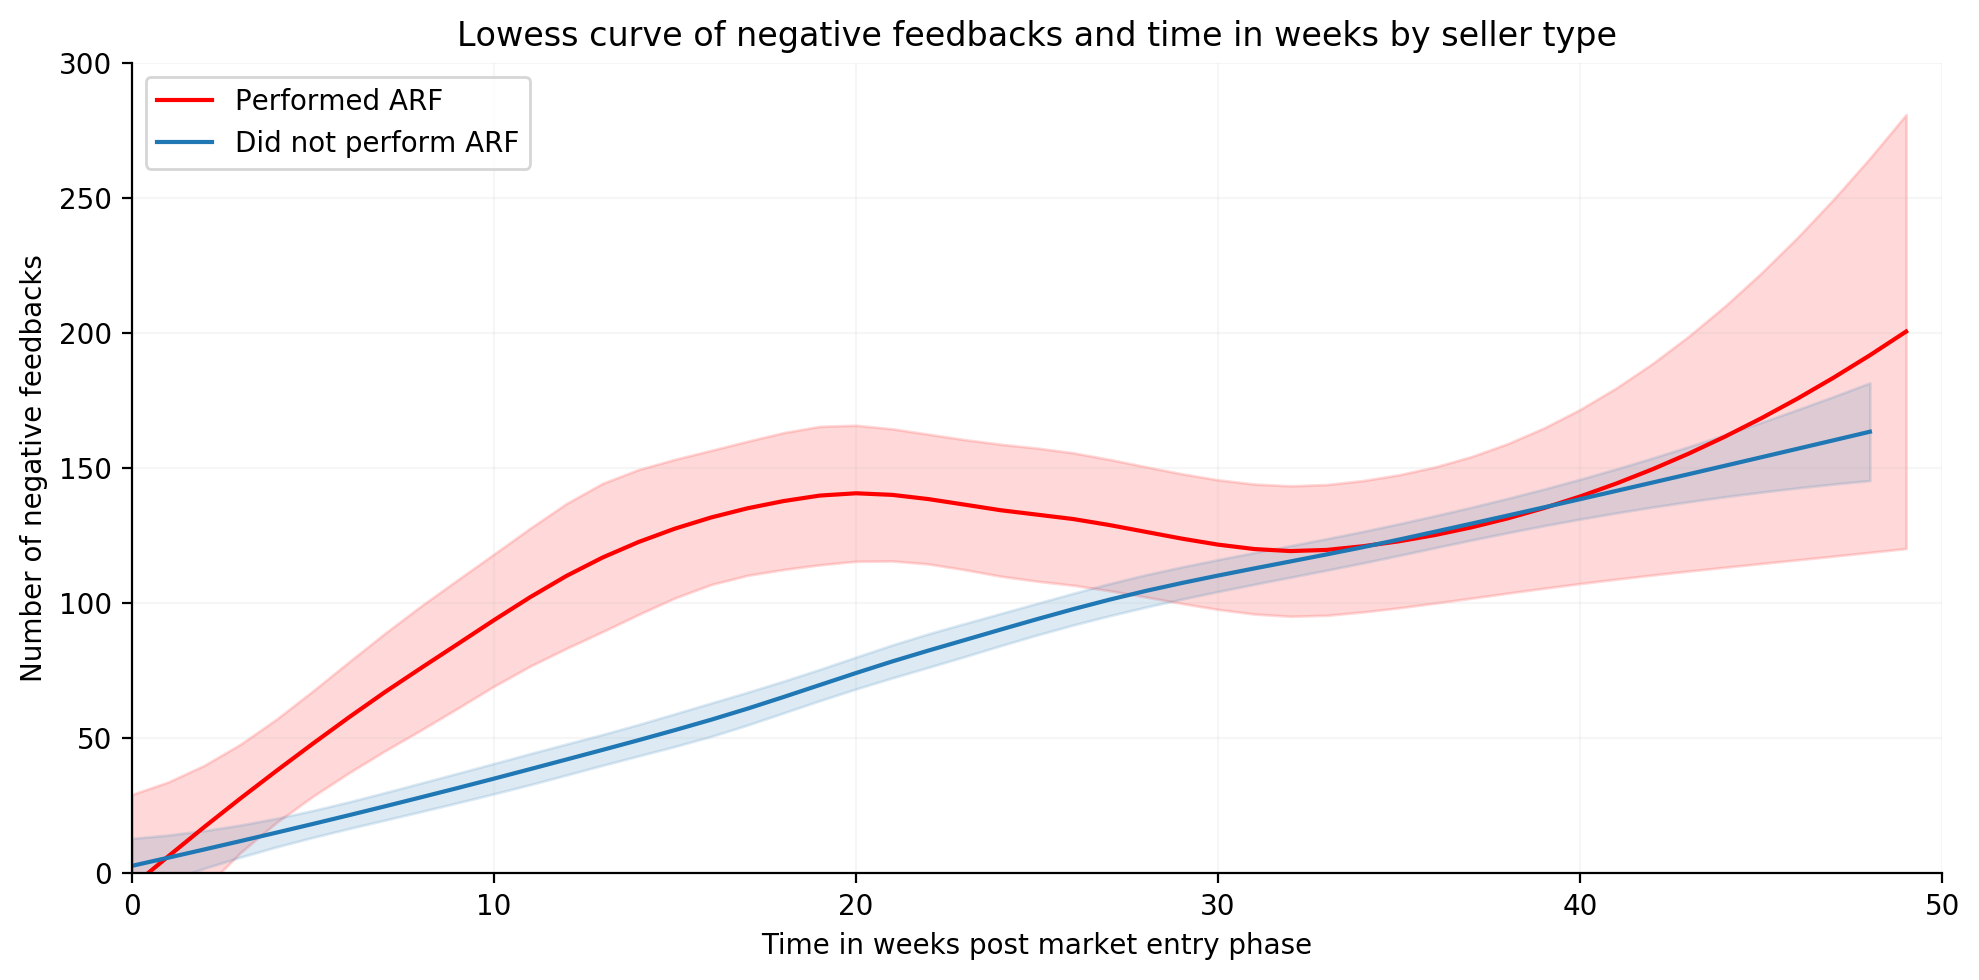

In [94]:
fig, ax = plt.subplots(figsize =  [10, 5])
ax.grid(True, which="both", ls="-", alpha = .1)

s = [df['arf'], ~df['arf']]
c = ['red', '#1f77b4']
l = ['Performed ARF', 'Did not perform ARF']

for selection, color, label in zip(s, c, l):
    # preprocess data
    data = df[selection].sort_values('w').copy()
    y = data['neg_count_min'].to_numpy()
    x = data['w'] - 2
    x_ = x.unique()

    # fit and predict lowess curve
    l = loess(x.to_numpy(), y, frac=0.1)
    l.fit()
    pred  = l.predict(x_, stderror=True)
    val   = pred.values
    conf  = pred.confidence()
    lower = conf.lower
    upper = conf.upper

    # plot lowess curve with 95% confidence
    ax.plot(x_, val, color=color, label = label)
    ax.fill_between(x_, lower, upper, alpha=.15, color=color)

ax.set_xlim(0, 50)
ax.set_ylim(0, 300)

# set titles and axes labels
ax.set_title('Lowess curve of negative feedbacks and time in weeks by seller type')
ax.set_ylabel('Number of negative feedbacks')
ax.set_xlabel('Time in weeks post market entry phase')
ax.legend(loc = 'upper left')

# show plot
plt.tight_layout()
plt.show()

In [ ]:
%%stata -d df

// normalize features
gen ln_neg_count_min = ln(neg_count_min)
replace ln_neg_count_min = 0 if ln_neg_count_min == .
gen ln_pos_count_min = ln(pos_count_min)
gen ln_w = ln(w)

// group items in terciles
gen items = .
replace items = 0 if item_count_w <=13
replace items = 1 if item_count_w > 13 & item_count_w <= 32
replace items = 2 if item_count_w > 32

// group size in terciles
gen size = .
replace size = 0 if cum_count <= 849
replace size = 1 if cum_count > 849 & count <= 3170
replace size = 2 if cum_count > 3170

recode m_maxw (1/3 = 1) (4/6 = 2) (6/9 = 3) (10/12 = 4), gen(q)

mepoisson ln_neg_count_min c.arf i.q international_shipment i.items i.size category_count || w: 

# ARM

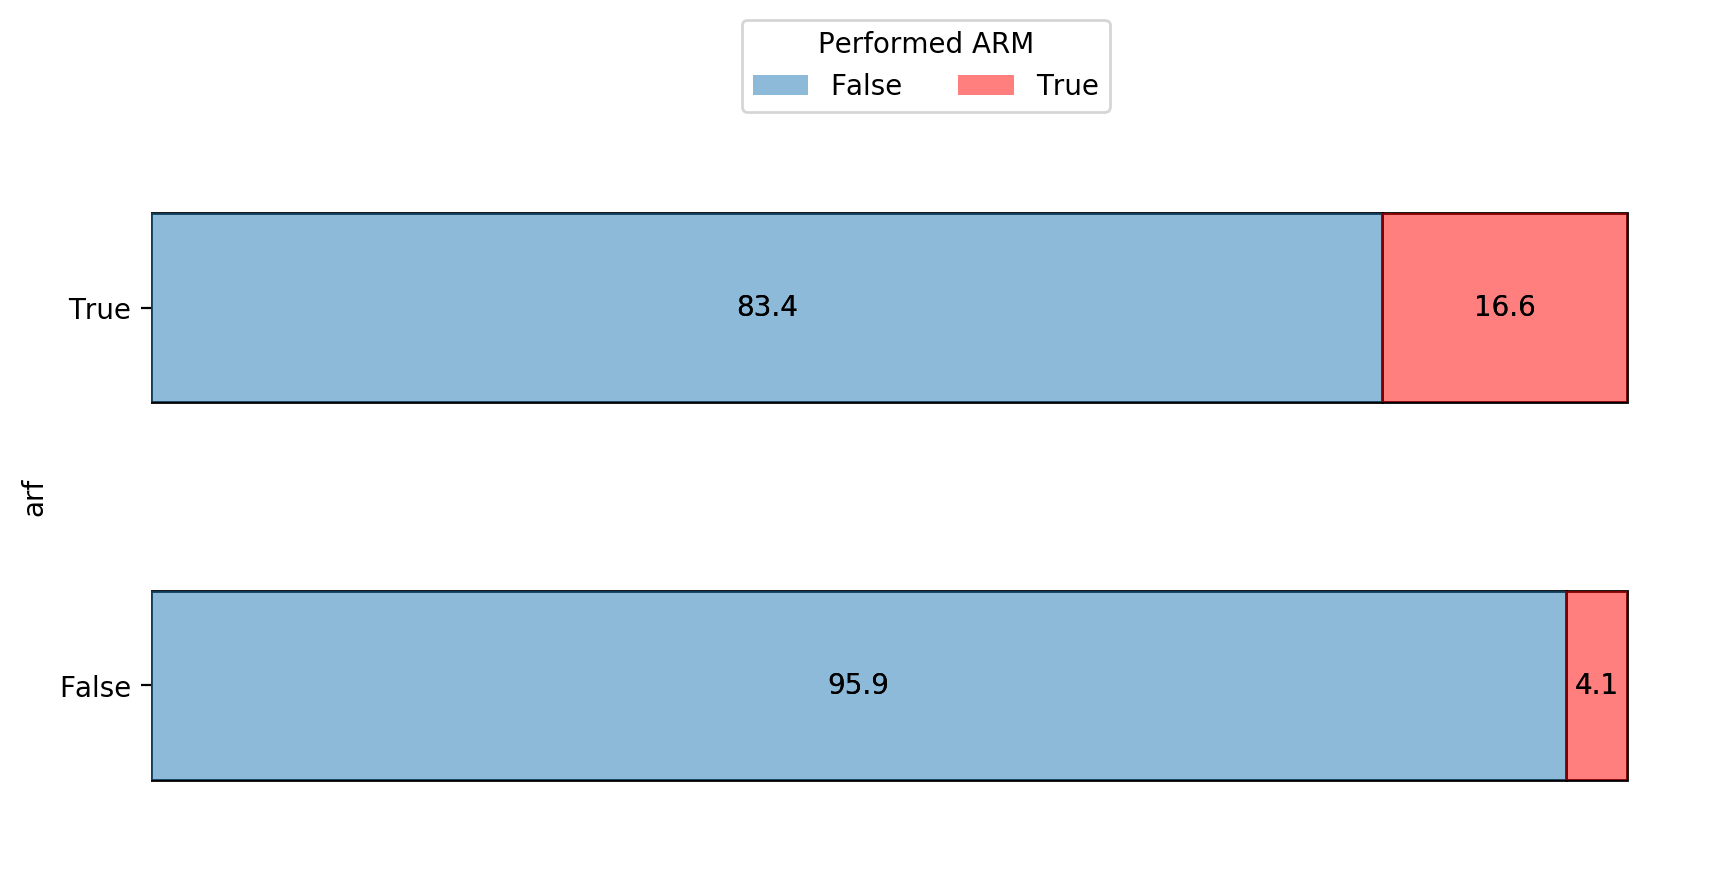

In [98]:
ct = pd.crosstab(df['arf'], df['arm_maxw'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ax.invert_yaxis()

ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5) 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          loc='upper center', bbox_to_anchor=(0.5, 1.15), 
          ncol = 2, title = 'Performed ARM')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.show()

In [139]:
%%stata -d df

// normalize features
gen ln_neg_count_min = ln(neg_count_min/100)
replace ln_neg_count_min = 0 if ln_neg_count_min == .
gen ln_pos_count_min = ln(pos_count_min/100)
gen ln_w = ln(w)

// group items in terciles
gen items = .
replace items = 0 if item_count <=13
replace items = 1 if item_count > 13 & item_count <= 32
replace items = 2 if item_count > 32

// group size in terciles
gen size = .
replace size = 0 if cum_count <= 849
replace size = 1 if cum_count > 849 & count <= 3170
replace size = 2 if cum_count > 3170

recode m_maxw (1/3 = 1) (4/6 = 2) (6/9 = 3) (9/12 = 4), gen(q)

melogit arm_maxw_shift                         ///
        c.ln_neg_count_min#c.arf               /// 
        c.ln_neg_count_min                     ///
        c.ln_pos_count_min                     ///
        c.w i.q i.items i.size                 ///
        international_shipment has_price_drop  ///
    || vendor: arf


. gen ln_neg_count_min = ln(neg_count_min/100)
(0 real changes made)
. gen items = .
(23,511 missing values generated)
(7,977 real changes made)
(7,754 real changes made)
(7,780 real changes made)
. gen size = .
(23,511 missing values generated)
(7,628 real changes made)
(12,326 real changes made)
(7,945 real changes made)
(12556 differences between m_maxw and q)
>         c.ln_neg_count_min#c.arf               /// 
>         c.ln_neg_count_min                     ///
>         c.ln_pos_count_min                     ///
>         c.w i.q i.items i.size                 ///
>         international_shipment has_price_drop  ///
>     || vendor: arf

Fitting fixed-effects model:

Iteration 0:   log likelihood = -6470.0083  
Iteration 1:   log likelihood =  -5867.129  
Iteration 2:   log likelihood = -5851.5526  
Iteration 3:   log likelihood = -5851.5252  
Iteration 4:   log likelihood = -5851.5252  

Refining starting values:

Grid node 0:   log likelihood = -5080.1425

Fitting full model

# Selling Price Adjustment

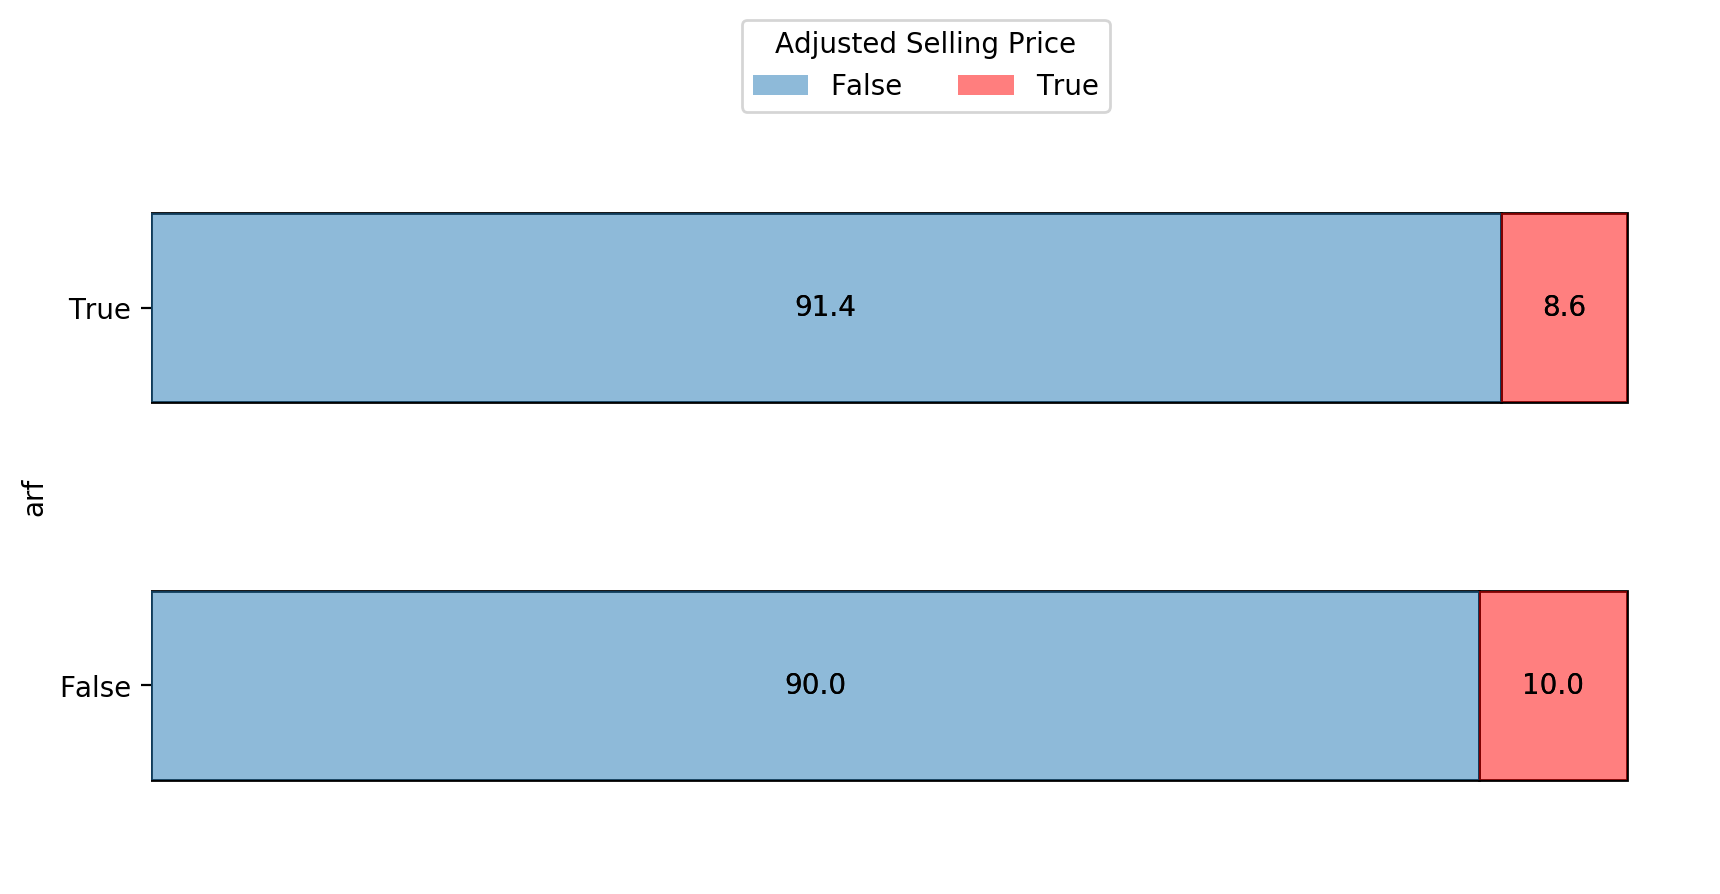

In [51]:
ct = pd.crosstab(df['arf'], df['has_price_drop'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5)
ax.invert_yaxis() 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol = 2, title = 'Adjusted Selling Price')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')
        
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.invert_yaxis()
plt.xticks([])
plt.show()

In [138]:
%%stata -d df
// normalize features
gen ln_neg_count_min = ln(neg_count_min)
replace ln_neg_count_min = 0 if ln_neg_count_min == .
gen ln_pos_count_min = ln(pos_count_min)
gen ln_w = ln(w)

// group items in terciles
gen items = .
replace items = 0 if item_count <=13
replace items = 1 if item_count > 13 & item_count <= 32
replace items = 2 if item_count > 32

// group size in terciles
gen size = .
replace size = 0 if cum_count <= 849
replace size = 1 if cum_count > 849 & count <= 3170
replace size = 2 if cum_count > 3170

recode m_maxw (1/3 = 1) (4/6 = 2) (6/9 = 3) (9/12 = 4), gen(q)

melogit has_price_drop_shift                   ///
        c.ln_neg_count_min#c.arf               /// 
        c.ln_neg_count_min                     ///
        c.ln_pos_count_min                     ///
        c.w i.q i.items i.size                 ///
        international_shipment arm_maxw        ///
    || vendor: arf


. gen ln_neg_count_min = ln(neg_count_min)
(0 real changes made)
. gen items = .
(23,511 missing values generated)
(7,977 real changes made)
(7,754 real changes made)
(7,780 real changes made)
. gen size = .
(23,511 missing values generated)
(7,628 real changes made)
(12,326 real changes made)
(7,945 real changes made)
(12556 differences between m_maxw and q)
>         c.ln_neg_count_min#c.arf               /// 
>         c.ln_neg_count_min                     ///
>         c.ln_pos_count_min                     ///
>         c.w i.q i.items i.size                 ///
>         international_shipment arm_maxw                ///
>     || vendor: arf

Fitting fixed-effects model:

Iteration 0:   log likelihood = -8670.1478  
Iteration 1:   log likelihood = -8446.2388  
Iteration 2:   log likelihood =  -8443.333  
Iteration 3:   log likelihood = -8443.3298  
Iteration 4:   log likelihood = -8443.3298  

Refining starting values:

Grid node 0:   log likelihood = -8661.2893

Fitting full m